#  Bi-LSTM (Bidirectional Long Short-Term Memory)
In this notebook, we will train and evaluate a Bi-LSTM model to predict HL phase transitions.

Long Short-Term Memory (LSTM) networks are particularly effective when working with sequential data, as they are designed to capture long-term dependencies. Unlike traditional recurrent neural networks (RNNs), LSTMs have memory cells that allow them to retain information over long sequences. Each LSTM unit contains three types of gates:

*   Forget gate: Decides which information to discard.
*   Input gate: Determines which new information to add to the memory.
*   Output gate: Decides what information to output based on both the input and the memory state.

LSTMs are useful for tasks where past information is relevant to future predictions. In this notebook, we hypothesize that LSTMs can learn useful patterns from sequential data to predict HL phase transitions.

In particular, we will explore Bidirectional LSTMs (Bi-LSTM), which extend traditional LSTMs by processing sequential data in both forward and backward directions. This allows the model to capture dependencies not only from past events (forward pass) but also from future events (backward pass). A Bi-LSTM consists of two LSTM layers: one processing the sequence from start to end, and the other processing it from end to start. The hidden states from both directions are then combined at each time step.

Finally, the output from the Bi-LSTM layers will be passed to a fully connected layer, followed by a sigmoid activation function. The model will output a binary classification: 1 if a phase transition occurs, and 0 if it does not.

In this notebook, we will train the Bi-LSTM model using pre-processed input data.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

First, we import all required packages, define global constants, and seed the random number generators to obtain reproducible results.\

In [2]:
# Install libraries if they are not already installed
# Uncomment and run the following lines if needed

# !pip install pandas
# !pip install numpy
# !pip install torch
# !pip install scikit-learn
# !pip install matplotlib
#!pip install keras
#!pip install dask[dataframe]
#!pip install optuna

# Import librairies
import os
import glob
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import StandardScaler
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler
import matplotlib.pyplot as plt

import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import matplotlib.pyplot as plt
import scipy.special
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection


import random
import dask.dataframe as dd

###Model
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras import backend as K

import optuna


from collections import Counter
import tensorflow as tf

import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
##REPRODUCIBILITY
torch.manual_seed(0)
np.random.seed(0)



Next, we will import the dataset. In this case we can use the different folders we created during the pre-processing. You can change the folder by changing the corresponding path

In [3]:
# Definition of paths and loading data

pq_path = 'preprocessed_features1_FFT'
pq_all = glob.glob(os.path.join(pq_path, '*_processed.parquet'))
pq_all = {int(os.path.basename(f).split("_processed.parquet")[0]): f for f in pq_all}

shotlist_all = list(pq_all.keys())

#with open('/content/drive/MyDrive/Colab Notebooks/ml-project-2-m-p-lasma/HL_times.json', 'r') as f:
with open('HL_times_sel.json', 'r') as f:
    HL_times = json.load(f)
    HL_times = {int(k): v for k, v in HL_times.items()}

print(f"Total number of experiments: {len(shotlist_all)}")
print(f"Total number of shots with HL transition times: {len(HL_times)}")


Total number of experiments: 244
Total number of shots with HL transition times: 245



We prepare the dataset for the analyis. We divide the shots in training, validation and test set. For consistency we want to ensure that all windows from the same shot are put into the same subset, to avoid using similira windows in train and then validation/test.

In [4]:
def split_shots(selected_shots, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    """
    Splits a list of shots into training, validation, and testing subsets based on specified ratios.
    We used this to split beforehand the shots into training, validation and test set to ensure that all the windows of the same shot are in the same subset.

    Args:
        selected_shots (list): list of selected shots to be split.
        train_ratio (float, optional): Proportion of the data to allocate to the training set. Defaults to 0.7.
        val_ratio (float, optional): Proportion of the data to allocate to the validation set. Defaults to 0.15.
        test_ratio (float, optional): Proportion of the data to allocate to the testing set. Defaults to 0.15.
        seed (int, optional): A seed for the random number generator to ensure reproducibility. Defaults to None.

    Returns:
        tuple: A tuple containing three lists:
            - train_shots: The training subset.
            - val_shots: The validation subset.
            - test_shots: The testing subset.
    """
    if seed is not None:
        random.seed(seed)  # For reproducibility

    random.shuffle(selected_shots) # Shuffle the shots

    total_shots = len(selected_shots)
    train_size = int(total_shots * train_ratio)
    val_size = int(total_shots * val_ratio)

    train_shots = selected_shots[:train_size]
    val_shots = selected_shots[train_size:train_size + val_size]
    test_shots = selected_shots[train_size + val_size:]

    return train_shots, val_shots, test_shots

train, val, test = split_shots(shotlist_all, train_ratio=0.7, test_ratio=0.15, val_ratio=0.15, seed=42)
print("The number of shots used for train is ", len(train) )
print("The number of shots used for validation is", len(val) )
print("The number of shots used for test is ", len(test) )

The number of shots used for train is  170
The number of shots used for validation is 36
The number of shots used for test is  38


In this section, we create a dask.dataframe to efficiently handle larger-than-memory datasets. Dask provides parallelized computations, which allows for the processing of large plasma datasets that may not fit entirely into memory. By leveraging Dask's ability to distribute the workload across multiple cores or machines, we can handle the dataset in chunks, ensuring scalability and faster processing, even with massive amounts of data. This approach is particularly useful for analyzing complex plasma data in tokamak experiments.

In [5]:

ddf = dd.concat([dd.read_parquet(pq_all[shot]) for shot in shotlist_all])
feature_columns = [col for col in ddf.columns if col != 'time']

global_mean = ddf[feature_columns].mean().compute()
global_std = ddf[feature_columns].std().compute()

print("Global Mean:\n", global_mean)
print("Global Std:\n", global_std)

Global Mean:
 Wtot             8.581349e+03
DML             -5.027588e-04
FIR_LIDs_core    3.018189e+19
FIR_LIDs_LFS     1.075033e+19
FIR_LIDs_HFS     9.028350e+18
                     ...     
Ne_rho_z64       1.499508e+19
Ne_rho_z65       1.479964e+19
Ne_rho_z66       1.460450e+19
Ne_rho_z67       1.440975e+19
Halpha13_FFT    -1.819958e-01
Length: 143, dtype: float64
Global Std:
 Wtot             5.349406e+03
DML              9.534639e-04
FIR_LIDs_core    1.542998e+19
FIR_LIDs_LFS     7.671220e+18
FIR_LIDs_HFS     6.586604e+19
                     ...     
Ne_rho_z64       9.995942e+18
Ne_rho_z65       9.896479e+18
Ne_rho_z66       9.798697e+18
Ne_rho_z67       9.702673e+18
Halpha13_FFT     2.886713e+03
Length: 143, dtype: float64


Next, we will create the windows we will use to train the model. We also performed different experiments by varying the time window size. We tested the following windows: 0.05, 0.1, and 0.2 seconds. The choice of window size can influence the granularity of the data and the model’s ability to capture phase transitions, so it is important to evaluate different options.

To achieve this, we will create standardized data windows from the input data, and assign corresponding labels based on whether a phase transition occurs within each window. The windows will be processed and split into training, validation, and test sets. Depending on the window size chosen, we will adjust the number of steps per window to ensure consistent data representation.

In [6]:
#Try window sizes of 0.1, 0.2 and 0.3

def create_windows_and_labels(selected_shots_number, pq_all, HL_times,
                              shot_number_train_set, shot_number_test_set,
                              shot_number_val_set, window_size=0.1,
                              global_mean=None, global_std=None):
    """
      Creates standardized windows of data and corresponding labels for training, validation, and testing.
      The label of each window corresponds to 1 if there is a phase transition and to 0 if no phase transition is observed

      Args:
          selected_shots_number (list): List of shot numbers to process.
          pq_all (dict): Dictionary mapping shot numbers to file paths of parquet data files.
          HL_times (dict): Dictionary where keys are shot numbers and values are lists of transition times.
          shot_number_train_set (set): Set of shot numbers allocated to the training dataset.
          shot_number_test_set (set): Set of shot numbers allocated to the testing dataset.
          shot_number_val_set (set): Set of shot numbers allocated to the validation dataset.
          window_size (float, optional): Size of each time window in seconds. Defaults to 0.1.
          global_mean (pd.Series, optional): Precomputed global mean for standardizing features.
          global_std (pd.Series, optional): Precomputed global standard deviation for standardizing features.

      Returns:
          tuple: A tuple containing six lists:
              - windows_train (list): List of standardized windows for the training dataset.
              - labels_train (list): List of labels corresponding to `windows_train`.
              - windows_test (list): List of standardized windows for the testing dataset.
              - labels_test (list): List of labels corresponding to `windows_test`.
              - windows_val (list): List of standardized windows for the validation dataset.
              - labels_val (list): List of labels corresponding to `windows_val`.
    """

    windows_train, labels_train = [], []
    windows_test, labels_test = [], []
    windows_val, labels_val = [], []

    # Load all data using Dask
    all_data = dd.concat([dd.read_parquet(pq_all[shot]) for shot in selected_shots_number])
    feature_columns = [col for col in all_data.columns if col != 'time']

    # Use precomputed global mean and std
    if global_mean is None or global_std is None:
        raise ValueError("Global mean and standard deviation must be provided.")
    print("Using precomputed global mean and std.")

    for shot_number in selected_shots_number:

        # Load shot data
        shot_data = pd.read_parquet(pq_all[shot_number])
        #shot_data.interpolate(method='linear', inplace=True)
        shot_data.dropna(inplace=True)

        time_values = shot_data['time'].values
        feature_values = shot_data[feature_columns].values
        transition_times = np.array(HL_times.get(shot_number, []))

        # Define time window indices
        start_time = time_values[0]
        end_time = time_values[-1]
        print(time_values)
        print("Start time:", start_time, "End time:", end_time, "Window size:", window_size)

        start_indices = np.searchsorted(time_values, np.arange(start_time, end_time, window_size))
        end_indices = np.searchsorted(time_values, np.arange(start_time + window_size, end_time + window_size, window_size))
        steps_per_window = 2000

        for start_idx, end_idx in zip(start_indices, end_indices):
            if start_idx == end_idx:  # Skip empty windows
                continue

            # Extract window and standardize using precomputed global stats
            window_array = (feature_values[start_idx:end_idx] - global_mean.values) / global_std.values

            if len(window_array) < steps_per_window:
              # Pad the window with NaNs if it's shorter than the required number of rows
              padding_needed = steps_per_window - len(window_array)
              padding_array = np.full((padding_needed, window_array.shape[1]), np.nan, dtype=np.float32)
              window_array = np.vstack([window_array, padding_array])

            elif len(window_array) >= steps_per_window:
              # Truncate the window if it has more rows than required
              window_array = window_array[:steps_per_window]
            else:
              # If exact match, directly use window_array
              pass

            # Label the window based on transition times
            current_time_start = time_values[start_idx]
            current_time_end = time_values[end_idx - 1]
            label = int(np.any((transition_times >= current_time_start) & (transition_times < current_time_end)))

            # Append to appropriate dataset
            if shot_number in shot_number_train_set:
                windows_train.append(window_array)
                labels_train.append(label)
            elif shot_number in shot_number_test_set:
                windows_test.append(window_array)
                labels_test.append(label)
            elif shot_number in shot_number_val_set:
                windows_val.append(window_array)
                labels_val.append(label)

    # Display shapes to check
    print(f"Number of windows_train: {len(windows_train)}")
    print(f"Shape of one window (train example): {windows_train[0].shape if windows_train else 'No data'}")
    print(f"Number of labels_train: {len(labels_train)}")
    print(f"Number of windows_test: {len(windows_test)}")
    print(f"Number of labels_test: {len(labels_test)}")
    print(f"Number of windows_val: {len(windows_val)}")
    print(f"Number of labels_val: {len(labels_val)}")

    return windows_train, labels_train, windows_test, labels_test, windows_val, labels_val


windows_train, labels_train, windows_test, labels_test, windows_val, labels_val = create_windows_and_labels(
    shotlist_all, pq_all, HL_times, train, test, val, window_size=0.2,
    global_mean=global_mean, global_std=global_std)


Using precomputed global mean and std.
[0.0344 0.0345 0.0346 ... 0.3573 0.3574 0.3575]
Start time: 0.0344 End time: 0.35750000000000004 Window size: 0.2
[0.03440104 0.03450105 0.03460106 ... 1.09059998 1.09069999 1.0908    ]
Start time: 0.03440103991006183 End time: 1.0908 Window size: 0.2
[0.1001 0.1002 0.1003 ... 1.6259 1.626  1.6261]
Start time: 0.1001 End time: 1.6261 Window size: 0.2
[0.0504 0.0505 0.0506 ... 1.9845 1.9846 1.9847]
Start time: 0.0504 End time: 1.9847000000000001 Window size: 0.2
[0.0504 0.0505 0.0506 ... 1.6434 1.6435 1.6436]
Start time: 0.0504 End time: 1.6436000000000002 Window size: 0.2
[0.0844 0.0845 0.0846 ... 0.9328 0.9329 0.933 ]
Start time: 0.0844 End time: 0.933 Window size: 0.2
[0.0504 0.0505 0.0506 ... 1.9305 1.9306 1.9307]
Start time: 0.0504 End time: 1.9307 Window size: 0.2
[0.0844 0.0845 0.0846 ... 0.9791 0.9792 0.9793]
Start time: 0.0844 End time: 0.9793000000000001 Window size: 0.2
[0.0504 0.0505 0.0506 ... 1.8309 1.831  1.8311]
Start time: 0.0504 E

## Defining a PyTorch Dataset for Time Windows
We create a custom dataset class, `HLTransitionWindowDataset`, which:
1. Accepts windowed data and labels.
2. Converts the data into tensors, making it suitable for PyTorch operations.

When loading the data we made the following considerations. During the training process, shuffling the data is crucial for ensuring that the model does not overfit to the specific order in which the data is presented. By randomizing the order of the training data, shuffling helps the model generalize better, preventing it from memorizing patterns that may only exist in the order of the data rather than the underlying relationships. However, when it comes to the validation set, shuffling may interfere with the objective of providing an unbiased evaluation. If the classes or data points are altered by shuffling, the validation set might not accurately reflect the real-world distribution of the data. Therefore, the validation data should remain consistent and reflect the natural distribution of the problem. Similarly, for the test set, it is important not to shuffle the data. The test set represents data that the model has not seen during training, and for a consistent evaluation, it should remain unchanged. The unaltered test data ensures that the model's performance is evaluated on a fixed set, offering a true measure of its generalization capabilities.


In [7]:
class HLTransitionWindowDataset(Dataset):
    def __init__(self, windowed_data, windowed_labels):
        self.windowed_data = windowed_data
        self.windowed_labels = windowed_labels

    def __len__(self):
        return len(self.windowed_data)

    def __getitem__(self, idx):
        X = torch.FloatTensor(self.windowed_data[idx])
        y = torch.FloatTensor([self.windowed_labels[idx]])
        return X, y


# Create datasets for training, validation, and testing
train_dataset = HLTransitionWindowDataset(windows_train, labels_train)
val_dataset = HLTransitionWindowDataset(windows_val, labels_val)
test_dataset = HLTransitionWindowDataset(windows_test, labels_test)

# Create DataLoaders for each dataset
batch_size = 64

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check shapes
for batch in train_data_loader:
    batch_x, batch_y = batch
    print("Shape of batch_x:", batch_x.shape)  # Shape of the input features
    print("Shape of batch_y:", batch_y.shape)  # Shape of the target labels
    break


Shape of batch_x: torch.Size([64, 2000, 143])
Shape of batch_y: torch.Size([64, 1])



In this section, we will define some essential functions for evaluating the model performance and preprocessing the data.

Given the nature of the task, where phase transitions are relatively rare events, we focus on F1 score rather than accuracy when evaluating the model. Accuracy can be misleading in imbalanced datasets, as a model could achieve high accuracy by simply predicting the majority class (no phase transition). Instead, F1 score provides a more balanced evaluation, making it a better choice for anomaly detection and ensuring that the model effectively identifies phase transitions. We will also explore different tresholds for the classification and try with higher decision boundaries than 0.5.

We then convert batches of data from PyTorch’s DataLoader to NumPy arrays. This is useful for handling data for the model which expects arrays. The conversion allows us to work with both the feature data (data_x) and corresponding labels (data_y) seamlessly.

In [8]:
def f1_score_metric(y_true, y_pred):

    """
    Calculate the F1 score for a binary classification task in Keras.
    The function uses Keras backend operations (`K.cast`, `K.greater`, `K.sum`, etc.)
    to compute the metrics in a manner suitable for Keras model training and evaluation.

    Args:
        y_true (tensor): Ground truth binary labels. A tensor of shape (batch_size, 1),
                          containing the true labels (0 or 1).
        y_pred (tensor): Predicted binary labels. A tensor of shape (batch_size, 1),
                         containing the predicted probabilities (values between 0 and 1).

    Returns:
        tensor: The F1 score calculated as 2 * (precision * recall) / (precision + recall).
                The value is between 0 and 1, where 1 is a perfect score.
    """

    # Convert predictions to binary (0 or 1) based on threshold 0.5 or 0.7
    y_pred = tf.cast(tf.greater(y_pred, 0.5), dtype=tf.float32)

    # True positives, predicted positives, and actual positives
    true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred))
    predicted_positives = tf.reduce_sum(y_pred)
    actual_positives = tf.reduce_sum(y_true)

    # Precision and recall
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())

    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    print('f1', f1)
    return f1

def replace_nans_with_mean(data):
    """
    Replace NaN values in a dataset with the mean of the respective columns.

    This function takes a 2D dataset (e.g., a NumPy array or list of lists), and
    replaces any NaN values with the mean of the respective column. The mean is
    calculated excluding NaN values.

    Args:
        data (array-like): Input dataset, which can be a list of lists or a NumPy array
                            where each column represents a feature, and NaN values are
                            present in some cells.

    Returns:
        numpy.ndarray: The dataset with NaN values replaced by the mean of each column.
    """
    data = np.array(data)
    for i in range(data.shape[1]):
        col = data[:, i]
        col_mean = np.nanmean(col)  # Calculate the mean excluding NaNs
        col[np.isnan(col)] = col_mean  # Replace NaNs with the calculated mean

    return data

def data_loader_to_numpy(data_loader):

    """
    Converts data from a PyTorch DataLoader to NumPy arrays.

    Args:
        data_loader (torch.utils.data.DataLoader): The DataLoader containing batches of data.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - data_x (np.ndarray): Concatenated feature data from all batches.
            - data_y (np.ndarray): Concatenated label data from all batches.
    """
    data_x = []
    data_y = []

    for batch_x, batch_y in data_loader:
        data_x.append(batch_x.numpy())  # Convert to NumPy
        data_y.append(batch_y.numpy())  # Convert to NumPy

    # Concatenate along the first axis (batch dimension)
    data_x = np.concatenate(data_x, axis=0)
    data_y = np.concatenate(data_y, axis=0)
    return data_x, data_y

def plot_metrics(history):
  """
  Plots the training and validation F1 score over epochs for model evaluation.

  Args:
  history (keras.callbacks.History): The history object returned by the model's `fit` method.
      It contains the training and validation metrics over epochs.

  This function generates a plot with two subplots:
  - The first subplot shows the F1 score for the training data.
  - The second subplot shows the F1 score for the validation data.

  The x-axis represents the number of epochs, while the y-axis represents the F1 score.
  """
  plt.figure(figsize=(12, 6))

  # Plot F1 score
  plt.subplot(1, 2, 2)
  plt.plot(history.history['f1_score_metric'], label='Train F1 Score')
  plt.plot(history.history['val_f1_score_metric'], label='Validation F1 Score')
  plt.title('F1 Score Over Epochs')
  plt.xlabel('Epoch')
  plt.ylabel('F1 Score')
  plt.legend()

  plt.show()



#Model Definition and Hyperparameter Optimization
We finally define the architecture for our model and we optimize it using several hyperparameters, including the number of LSTM units, dropout rate, learning rate, and batch size.

### Model Architecture
*  LSTM Layer: A bidirectional LSTM layer is used to capture dependencies from both past and future time steps in the sequence.
*  Dropout Layer: Dropout regularization is applied to prevent overfitting.
*  Batch Normalization: This layer helps stabilize and accelerate training by normalizing activations.
*  Fully connected layer: The final output is a single unit with a sigmoid activation function to predict binary class labels (phase transition: 1, no transition: 0). A kernel_regularizer with L2 regularization is applied to the weights of this layer to help reduce overfitting.

The model is compiled with:
Loss Function: binary_crossentropy for binary classification tasks.
Optimizer: The Adam optimizer is used with a custom learning rate (learning_rate) and gradient clipping (clipvalue=1.0) to prevent exploding gradients.
Metrics: The custom F1 score metric (f1_score_metric)

We use Optuna, an automatic hyperparameter optimization framework, to find the best combination of hyperparameters. The objective function is defined to maximize the F1 score on the validation set, ensuring that we choose the most effective configuration for our model.

The model is trained with early stopping to prevent overfitting, and the class weights are computed to address any class imbalance in the dataset. We also visualize the F1 score over the training and validation phases to assess model performance.

In [9]:
# Define the model function with hyperparameters
def get_classification_model(input_shape, lstm_units, dropout_rate, learning_rate):
    model = Sequential()

    model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(rate=dropout_rate))  # Dropout for regularization
    model.add(BatchNormalization())  # Batch Normalization for stabilizing training

    model.add(Bidirectional(LSTM(units=lstm_units)))
    model.add(Dropout(rate=dropout_rate))
    model.add(BatchNormalization())

    # Fully connected output layer
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))

    # Compile the model with F1 score as the metric
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)  # Gradient clipping with clipvalue
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1_score_metric])

    return model



# Objective function for hyperparameter optimization using Optuna
def objective(trial, x_train, y_train, x_val, y_val, input_shape):

    # Hyperparameter search space
    lstm_units = trial.suggest_int('lstm_units', 30, 128, step=32)  # Units in LSTM layer
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)  # Learning rate for optimizer
    batch_size = trial.suggest_int('batch_size', 32, 128, step=32)  # Batch size for training

    # Build the model with the chosen hyperparameters
    model = get_classification_model(input_shape, lstm_units, dropout_rate, learning_rate)

    # Flatten the labels for class weight computation
    y_train_flat = y_train.flatten()

    # Compute class weights to handle class imbalance
    label_counts = Counter(y_train_flat)
    total_samples = len(y_train_flat)
    class_weights = {label: total_samples / count for label, count in label_counts.items()}

    # Handle cases where invalid class weights may be detected
    if any(np.isnan(value) or np.isinf(value) for value in class_weights.values()):
        print("Invalid class weights detected.")

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        epochs=15,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=class_weights,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
        verbose=1
    )

    # After training, extract the best F1 score from the validation set
    best_f1_score = history.history['val_f1_score_metric'][-1]

    # Plot training/validation metrics for visualization
    plot_metrics(history)

    return best_f1_score

#We can now define the function for training our model
def train_model(x_train, y_train, x_val, y_val, input_shape):

    model = get_classification_model(input_shape)
    y_train_flat = y_train.flatten()

    # Computing class weights
    label_counts = Counter(y_train_flat)  # Counter expects 1D array, counts how many times each label appears in the training data
    total_samples = len(y_train)
    class_weights = {label: total_samples / count for label, count in label_counts.items()}

    if any(np.isnan(value) or np.isinf(value) for value in class_weights.values()):
        print("Invalid class weights detected.")

    # Train the model and store the history
    history = model.fit(
        x_train,
        y_train,
        epochs=15,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        class_weight=class_weights,
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)],
        verbose=1
    )

    # Plot training and validation accuracy and F1 score
    plot_metrics(history)

    return model, history


In [10]:
x_train_np, y_train_np = data_loader_to_numpy(train_data_loader)
x_val_np, y_val_np = data_loader_to_numpy(val_data_loader)



x_train_np = replace_nans_with_mean(x_train_np) #uncomment if doesn't work
x_val_np = replace_nans_with_mean(x_val_np)
# Uncomment below if NaN replacement is needed for y arrays
# y_train_np = replace_nans_with_mean(y_train_np)
# y_val_np = replace_nans_with_mean(y_val_np)

# Function to check for NaNs in arrays
def check_nans(*arrays):
    for i, arr in enumerate(arrays, 1):
        if np.isnan(arr).any():
            print(f"Array {i} contains NaNs.")
        else:
            print(f"Array {i} does not contain NaNs.")

# Check for NaNs in the datasets
check_nans(x_train_np, y_train_np, x_val_np, y_val_np)


Array 1 does not contain NaNs.
Array 2 does not contain NaNs.
Array 3 does not contain NaNs.
Array 4 does not contain NaNs.


[I 2024-12-19 02:25:56,509] A new study created in memory with name: no-name-a2f748c0-5960-4e77-b69b-1f8a4ed9ebb0
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [30, 128] and step=32, but the range is not divisible by `step`. It will be replaced by [30, 126].
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.5017 - loss: 1.2985f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - f1_score_metric: 0.5042 - loss: 1.2863 - val_f1_score_metric: 0.6506 - val_loss: 0.5173
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - f1_score_metric: 0.6262 - loss: 0.8050 - val_f1_score_metric: 0.6759 - val_loss: 0.4737
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - f1_score_metric: 0.6440 - loss: 0.7250 - val_f1_score_metric: 0.7280 - val_loss: 0.4274
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - f1_score_metric: 0.6612 - loss: 0.6507 - val_f1_score_metric: 0.6984 - val_loss: 0.4040
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - f1_score_metric: 0.7591 - loss: 0.5234 - val_f1_score_metric: 0.6862 - val_loss: 0.3832
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - f1_score_metric: 0.7

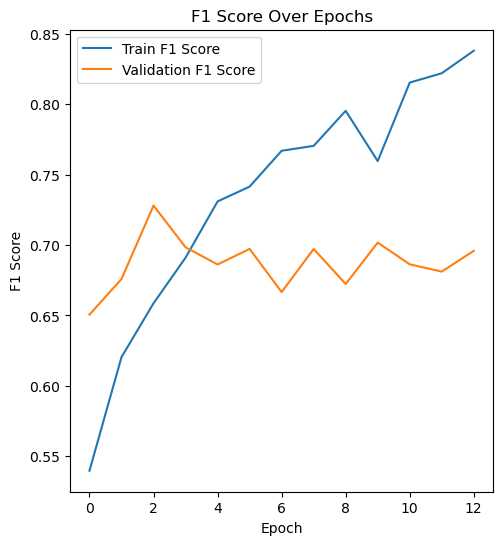

[I 2024-12-19 02:37:04,762] Trial 0 finished with value: 0.6959063410758972 and parameters: {'lstm_units': 126, 'dropout_rate': 0.20622558480782047, 'learning_rate': 0.0007960579883076775, 'batch_size': 96}. Best is trial 0 with value: 0.6959063410758972.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.2999 - loss: 1.6680f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.3013 - loss: 1.6604 - val_f1_score_metric: 0.5301 - val_loss: 0.6652
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - f1_score_metric: 0.4062 - loss: 1.3235 - val_f1_score_metric: 0.5412 - val_loss: 0.6403
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - f1_score_metric: 0.4708 - loss: 1.2277 - val_f1_score_metric: 0.5715 - val_loss: 0.6232
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - f1_score_metric: 0.4721 - loss: 1.1304 - val_f1_score_metric: 0.5779 - val_loss: 0.6132
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - f1_score_metric: 0.4873 - loss: 1.0919 - val_f1_score_metric: 0.5997 - val_loss: 0.6071
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - f1_score_metric: 0.5

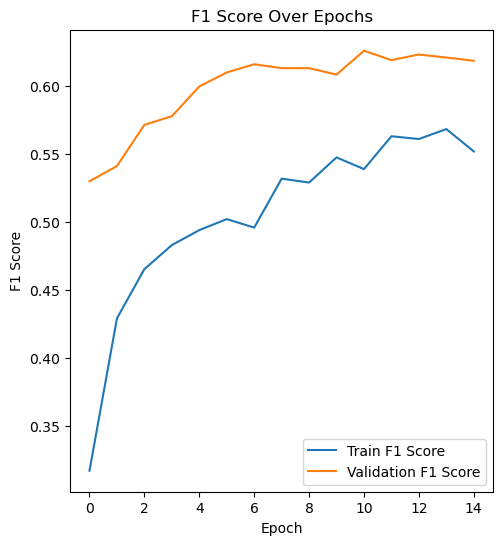

[I 2024-12-19 02:42:35,634] Trial 1 finished with value: 0.6186605095863342 and parameters: {'lstm_units': 62, 'dropout_rate': 0.26743899365925433, 'learning_rate': 3.92815480207914e-05, 'batch_size': 128}. Best is trial 0 with value: 0.6959063410758972.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - f1_score_metric: 0.3909 - loss: 1.4500f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 959ms/step - f1_score_metric: 0.3971 - loss: 1.4319 - val_f1_score_metric: 0.6589 - val_loss: 0.5722
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 956ms/step - f1_score_metric: 0.5489 - loss: 0.9362 - val_f1_score_metric: 0.6926 - val_loss: 0.5359
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 940ms/step - f1_score_metric: 0.5889 - loss: 0.8789 - val_f1_score_metric: 0.7398 - val_loss: 0.4988
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 956ms/step - f1_score_metric: 0.5930 - loss: 0.8308 - val_f1_score_metric: 0.7647 - val_loss: 0.4649
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 977ms/step - f1_score_metric: 0.6127 - loss: 0.7733 - val_f1_score_metric: 0.7715 - val_loss: 0.4434
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 962ms/step -

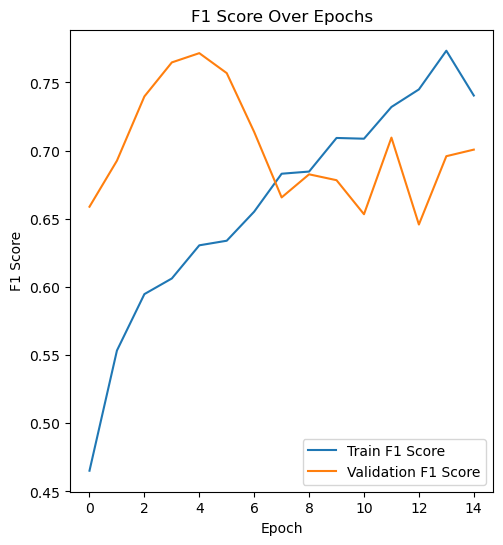

[I 2024-12-19 02:45:32,968] Trial 2 finished with value: 0.7007575631141663 and parameters: {'lstm_units': 30, 'dropout_rate': 0.2265019442522031, 'learning_rate': 0.001137835436206262, 'batch_size': 128}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - f1_score_metric: 0.4454 - loss: 1.2483f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 765ms/step - f1_score_metric: 0.4492 - loss: 1.2373 - val_f1_score_metric: 0.6105 - val_loss: 0.5037
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 734ms/step - f1_score_metric: 0.5870 - loss: 0.9974 - val_f1_score_metric: 0.6305 - val_loss: 0.4366
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 735ms/step - f1_score_metric: 0.5791 - loss: 0.9023 - val_f1_score_metric: 0.6582 - val_loss: 0.3946
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 742ms/step - f1_score_metric: 0.6354 - loss: 0.7437 - val_f1_score_metric: 0.6787 - val_loss: 0.3681
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 737ms/step - f1_score_metric: 0.6186 - loss: 0.7605 - val_f1_score_metric: 0.6606 - val_loss: 0.3469
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 751ms/step -

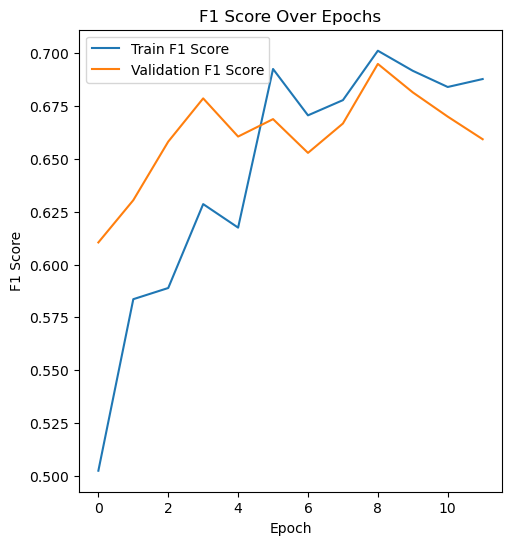

[I 2024-12-19 02:47:55,501] Trial 3 finished with value: 0.6593303680419922 and parameters: {'lstm_units': 30, 'dropout_rate': 0.353657679015733, 'learning_rate': 0.002740708741343239, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.4334 - loss: 1.5202f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.4385 - loss: 1.4986 - val_f1_score_metric: 0.5797 - val_loss: 0.3714
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.6067 - loss: 0.8709 - val_f1_score_metric: 0.6055 - val_loss: 0.3411
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.5926 - loss: 0.8192 - val_f1_score_metric: 0.6126 - val_loss: 0.3340
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.6463 - loss: 0.7438 - val_f1_score_metric: 0.6246 - val_loss: 0.3222
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.6823 - loss: 0.6751 - val_f1_score_metric: 0.6169 - val_loss: 0.3342
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - f1_score_metric: 0.6

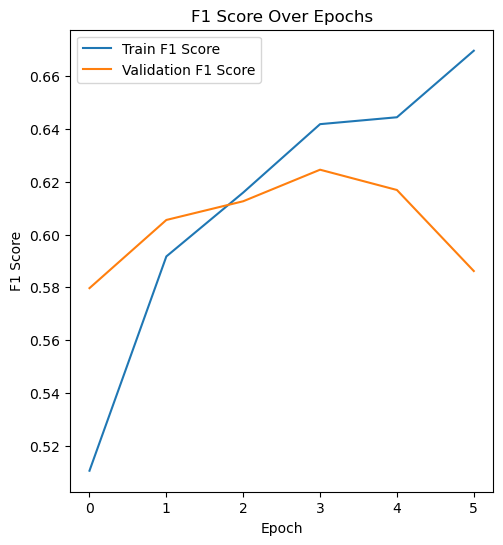

[I 2024-12-19 02:52:02,552] Trial 4 finished with value: 0.586165726184845 and parameters: {'lstm_units': 94, 'dropout_rate': 0.28756282045118997, 'learning_rate': 0.005666597524267947, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.3307 - loss: 1.6463f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.3361 - loss: 1.6266 - val_f1_score_metric: 0.5616 - val_loss: 0.6180
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.5200 - loss: 1.0661 - val_f1_score_metric: 0.6157 - val_loss: 0.5888
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.5659 - loss: 0.9380 - val_f1_score_metric: 0.6268 - val_loss: 0.5712
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.5666 - loss: 0.9082 - val_f1_score_metric: 0.6435 - val_loss: 0.5477
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.5686 - loss: 0.7901 - val_f1_score_metric: 0.6350 - val_loss: 0.5321
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.6

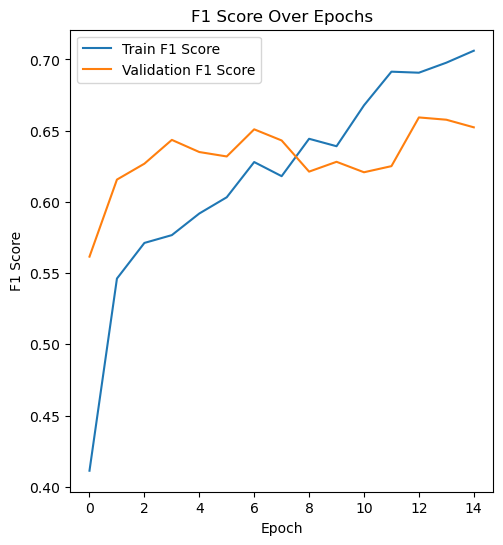

[I 2024-12-19 03:03:12,523] Trial 5 finished with value: 0.6523507237434387 and parameters: {'lstm_units': 94, 'dropout_rate': 0.2426510142804581, 'learning_rate': 0.00013183243694343358, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4879 - loss: 1.2181f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - f1_score_metric: 0.4894 - loss: 1.2141 - val_f1_score_metric: 0.6614 - val_loss: 0.5458
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.5852 - loss: 0.9576 - val_f1_score_metric: 0.6349 - val_loss: 0.5115
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6220 - loss: 0.8076 - val_f1_score_metric: 0.6261 - val_loss: 0.4578
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6030 - loss: 0.8180 - val_f1_score_metric: 0.6398 - val_loss: 0.4450
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6610 - loss: 0.7003 - val_f1_score_metric: 0.6809 - val_loss: 0.4147
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6

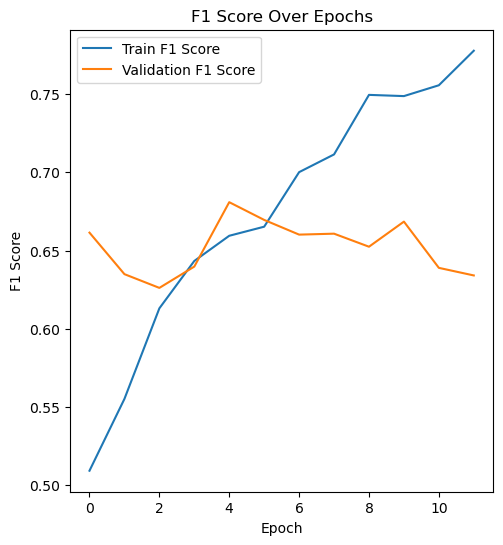

[I 2024-12-19 03:08:10,073] Trial 6 finished with value: 0.6340931057929993 and parameters: {'lstm_units': 62, 'dropout_rate': 0.3302041979999881, 'learning_rate': 0.0007133471581159139, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.4964 - loss: 1.0721f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.4979 - loss: 1.0721 - val_f1_score_metric: 0.6286 - val_loss: 0.4453
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - f1_score_metric: 0.6039 - loss: 0.8255 - val_f1_score_metric: 0.6263 - val_loss: 0.3697
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.6663 - loss: 0.6735 - val_f1_score_metric: 0.6405 - val_loss: 0.3314
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.6243 - loss: 0.7655 - val_f1_score_metric: 0.5809 - val_loss: 0.3297
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - f1_score_metric: 0.7098 - loss: 0.6111 - val_f1_score_metric: 0.5718 - val_loss: 0.3328
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - f1_score_metric: 0.6

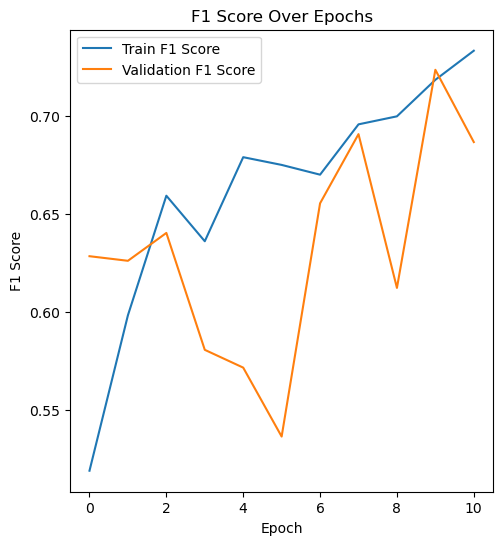

[I 2024-12-19 03:16:21,457] Trial 7 finished with value: 0.6868093609809875 and parameters: {'lstm_units': 94, 'dropout_rate': 0.38031168602136334, 'learning_rate': 0.002604171552863375, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.3441 - loss: 1.5357f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - f1_score_metric: 0.3452 - loss: 1.5329 - val_f1_score_metric: 0.5201 - val_loss: 0.6640
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - f1_score_metric: 0.4274 - loss: 1.3061 - val_f1_score_metric: 0.5586 - val_loss: 0.6442
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - f1_score_metric: 0.5089 - loss: 1.1176 - val_f1_score_metric: 0.5891 - val_loss: 0.6322
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - f1_score_metric: 0.4832 - loss: 1.1253 - val_f1_score_metric: 0.5894 - val_loss: 0.6237
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - f1_score_metric: 0.4739 - loss: 1.1087 - val_f1_score_metric: 0.5896 - val_loss: 0.6165
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - f1_score_metric: 0.5

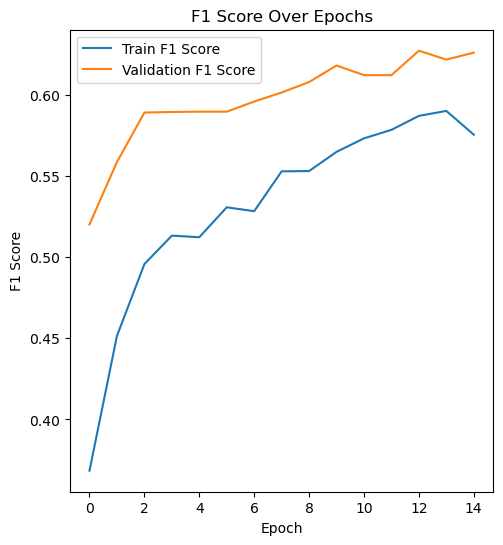

[I 2024-12-19 03:33:28,914] Trial 8 finished with value: 0.6259498000144958 and parameters: {'lstm_units': 126, 'dropout_rate': 0.29577082669656357, 'learning_rate': 1.8680050579021803e-05, 'batch_size': 64}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - f1_score_metric: 0.2807 - loss: 1.7516f1 Tensor("truediv_2:0", shape=(), dtype=float32)
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 831ms/step - f1_score_metric: 0.2817 - loss: 1.7535 - val_f1_score_metric: 0.3569 - val_loss: 0.7188
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 849ms/step - f1_score_metric: 0.3132 - loss: 1.6078 - val_f1_score_metric: 0.3763 - val_loss: 0.7104
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 814ms/step - f1_score_metric: 0.3510 - loss: 1.6163 - val_f1_score_metric: 0.4037 - val_loss: 0.7011
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - f1_score_metric: 0.3078 - loss: 1.5057 - val_f1_score_metric: 0.4187 - val_loss: 0.6925
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 803ms/step - f1_score_metric: 0.3191 - loss: 1.5098 - val_f1_score_metric: 0.4408 - val_loss: 0.6831
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 812ms/step -

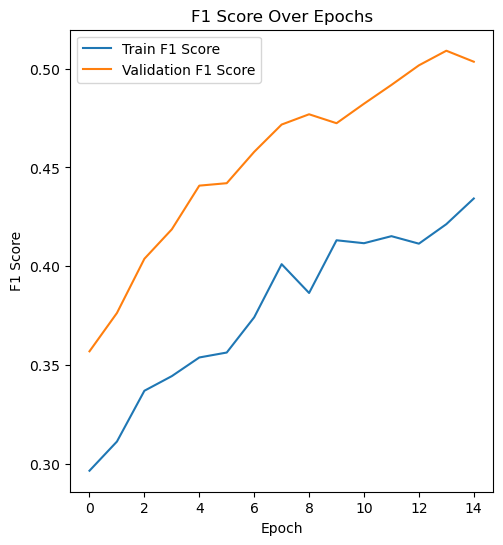

[I 2024-12-19 03:36:39,577] Trial 9 finished with value: 0.5035563111305237 and parameters: {'lstm_units': 30, 'dropout_rate': 0.448604397892303, 'learning_rate': 1.3825758230956736e-05, 'batch_size': 96}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - f1_score_metric: 0.3680 - loss: 1.3452f1 Tensor("truediv_2:0", shape=(), dtype=float32)
42/42 ━━━━━━━━━━━━━━━━━━━━ 21s 460ms/step - f1_score_metric: 0.3696 - loss: 1.3440 - val_f1_score_metric: 0.5950 - val_loss: 0.5985
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - f1_score_metric: 0.4797 - loss: 1.1346 - val_f1_score_metric: 0.6204 - val_loss: 0.5557
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - f1_score_metric: 0.5397 - loss: 1.0539 - val_f1_score_metric: 0.6193 - val_loss: 0.5293
Epoch 4/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 544ms/step - f1_score_metric: 0.5112 - loss: 1.0597 - val_f1_score_metric: 0.6430 - val_loss: 0.4977
Epoch 5/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 547ms/step - f1_score_metric: 0.5027 - loss: 0.9555 - val_f1_score_metric: 0.6355 - val_loss: 0.4901
Epoch 6/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 548ms/step -

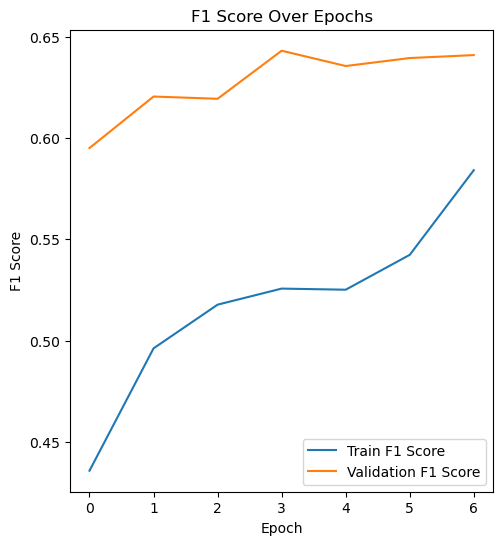

[I 2024-12-19 03:39:13,733] Trial 10 finished with value: 0.6408407092094421 and parameters: {'lstm_units': 30, 'dropout_rate': 0.49312767572015515, 'learning_rate': 0.00016794092914990146, 'batch_size': 32}. Best is trial 2 with value: 0.7007575631141663.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - f1_score_metric: 0.4307 - loss: 1.4359f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - f1_score_metric: 0.4366 - loss: 1.4164 - val_f1_score_metric: 0.6879 - val_loss: 0.5914
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - f1_score_metric: 0.5931 - loss: 0.8401 - val_f1_score_metric: 0.6801 - val_loss: 0.5148
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - f1_score_metric: 0.6590 - loss: 0.7492 - val_f1_score_metric: 0.6929 - val_loss: 0.4939
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step - f1_score_metric: 0.6626 - loss: 0.6697 - val_f1_score_metric: 0.7109 - val_loss: 0.4586
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.6658 - loss: 0.6370 - val_f1_score_metric: 0.7202 - val_loss: 0.4199
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.7

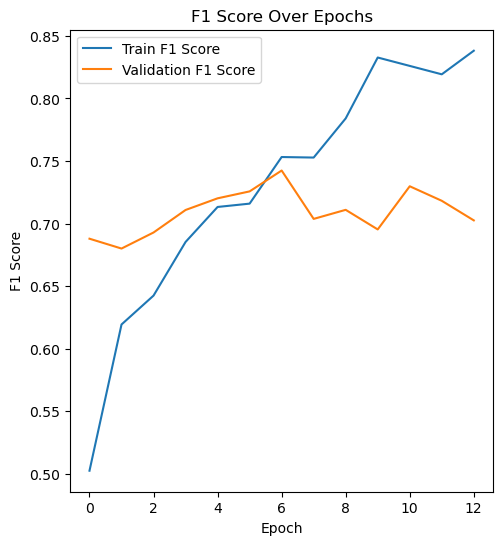

[I 2024-12-19 03:51:46,113] Trial 11 finished with value: 0.7025724053382874 and parameters: {'lstm_units': 126, 'dropout_rate': 0.20092677051689975, 'learning_rate': 0.0005630074871552249, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.3916 - loss: 1.4248f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - f1_score_metric: 0.3991 - loss: 1.4075 - val_f1_score_metric: 0.6488 - val_loss: 0.5756
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.5590 - loss: 0.9773 - val_f1_score_metric: 0.7039 - val_loss: 0.5344
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6032 - loss: 0.8221 - val_f1_score_metric: 0.6392 - val_loss: 0.5132
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6432 - loss: 0.7430 - val_f1_score_metric: 0.6725 - val_loss: 0.4985
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.6802 - loss: 0.6967 - val_f1_score_metric: 0.6982 - val_loss: 0.4764
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - f1_score_metric: 0.7

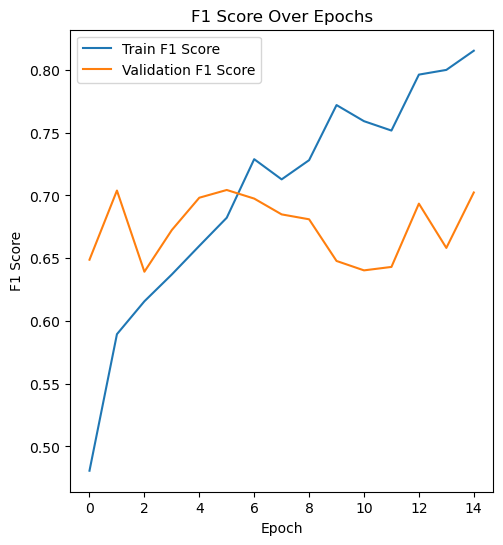

[I 2024-12-19 03:57:49,209] Trial 12 finished with value: 0.702380895614624 and parameters: {'lstm_units': 62, 'dropout_rate': 0.20057389211134663, 'learning_rate': 0.0006154590720149156, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.5087 - loss: 1.1490f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - f1_score_metric: 0.5097 - loss: 1.1447 - val_f1_score_metric: 0.6919 - val_loss: 0.5629
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.5793 - loss: 0.9429 - val_f1_score_metric: 0.7399 - val_loss: 0.5417
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6226 - loss: 0.8000 - val_f1_score_metric: 0.7192 - val_loss: 0.5192
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6365 - loss: 0.7906 - val_f1_score_metric: 0.6803 - val_loss: 0.4977
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6333 - loss: 0.7516 - val_f1_score_metric: 0.6885 - val_loss: 0.4828
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6

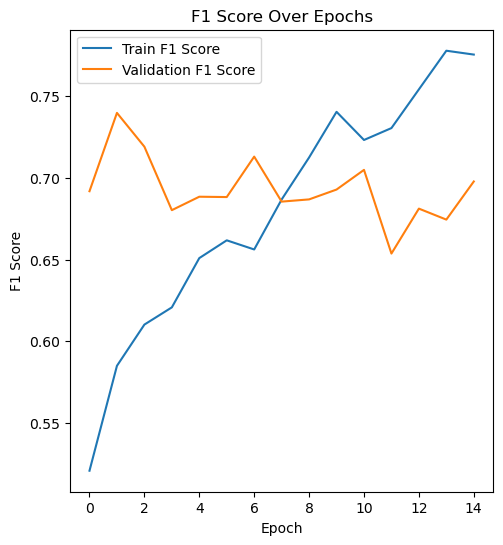

[I 2024-12-19 04:03:53,816] Trial 13 finished with value: 0.6978484988212585 and parameters: {'lstm_units': 62, 'dropout_rate': 0.20443039639774338, 'learning_rate': 0.00035042461796144856, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - f1_score_metric: 0.4112 - loss: 1.3832f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.4147 - loss: 1.3728 - val_f1_score_metric: 0.6501 - val_loss: 0.6117
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.5252 - loss: 1.0036 - val_f1_score_metric: 0.6947 - val_loss: 0.5917
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - f1_score_metric: 0.5729 - loss: 0.9040 - val_f1_score_metric: 0.6819 - val_loss: 0.5826
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - f1_score_metric: 0.5649 - loss: 0.9048 - val_f1_score_metric: 0.6959 - val_loss: 0.5750
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - f1_score_metric: 0.5936 - loss: 0.8817 - val_f1_score_metric: 0.7094 - val_loss: 0.5572
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.5

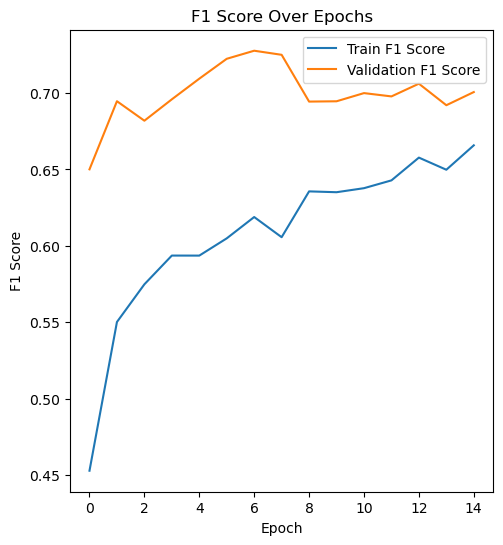

[I 2024-12-19 04:18:31,210] Trial 14 finished with value: 0.7006797790527344 and parameters: {'lstm_units': 126, 'dropout_rate': 0.24781733193693484, 'learning_rate': 7.273652142793822e-05, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4120 - loss: 1.5432f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - f1_score_metric: 0.4145 - loss: 1.5315 - val_f1_score_metric: 0.6417 - val_loss: 0.5501
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_score_metric: 0.5488 - loss: 0.9583 - val_f1_score_metric: 0.6887 - val_loss: 0.5105
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_score_metric: 0.5770 - loss: 0.8508 - val_f1_score_metric: 0.6633 - val_loss: 0.4635
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - f1_score_metric: 0.6090 - loss: 0.7488 - val_f1_score_metric: 0.6932 - val_loss: 0.4344
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - f1_score_metric: 0.6627 - loss: 0.7765 - val_f1_score_metric: 0.6682 - val_loss: 0.4198
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - f1_score_metric: 0.6

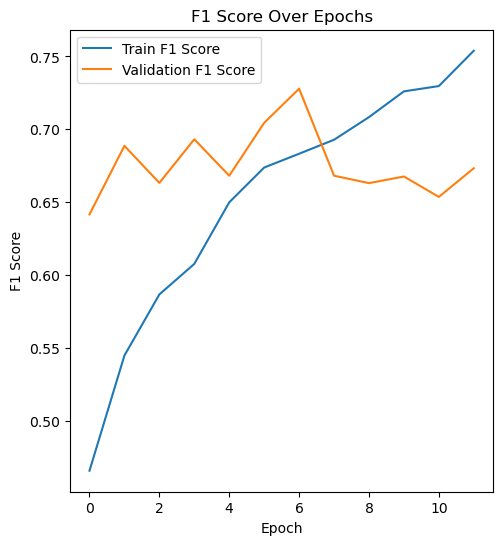

[I 2024-12-19 04:27:49,960] Trial 15 finished with value: 0.6733194589614868 and parameters: {'lstm_units': 94, 'dropout_rate': 0.40978355291499025, 'learning_rate': 0.0004142756419457908, 'batch_size': 64}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4935 - loss: 1.1876f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - f1_score_metric: 0.4955 - loss: 1.1796 - val_f1_score_metric: 0.5991 - val_loss: 0.4656
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.5861 - loss: 0.8638 - val_f1_score_metric: 0.5289 - val_loss: 0.4057
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6449 - loss: 0.7187 - val_f1_score_metric: 0.4048 - val_loss: 0.3688
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6949 - loss: 0.6388 - val_f1_score_metric: 0.2258 - val_loss: 0.3748
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.6943 - loss: 0.6541 - val_f1_score_metric: 0.2814 - val_loss: 0.3587
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - f1_score_metric: 0.7

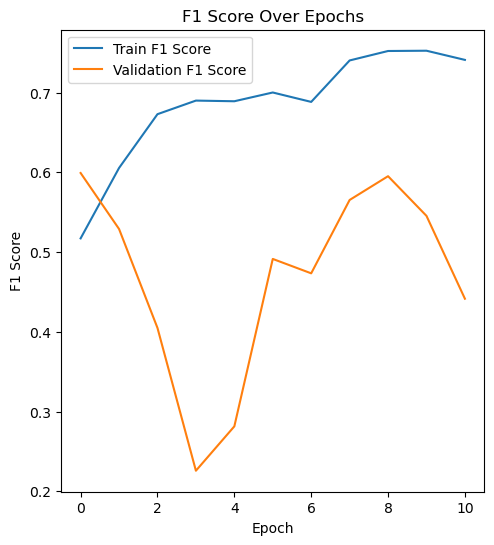

[I 2024-12-19 04:32:12,624] Trial 16 finished with value: 0.4414529800415039 and parameters: {'lstm_units': 62, 'dropout_rate': 0.3090738806611899, 'learning_rate': 0.0019527223230657745, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1_score_metric: 0.4750 - loss: 1.4899f1 Tensor("truediv_2:0", shape=(), dtype=float32)
42/42 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - f1_score_metric: 0.4757 - loss: 1.4839 - val_f1_score_metric: 0.6221 - val_loss: 0.3599
Epoch 2/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - f1_score_metric: 0.5779 - loss: 1.0270 - val_f1_score_metric: 0.5760 - val_loss: 0.3631
Epoch 3/15
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - f1_score_metric: 0.5844 - loss: 0.9360 - val_f1_score_metric: 0.6224 - val_loss: 0.4145


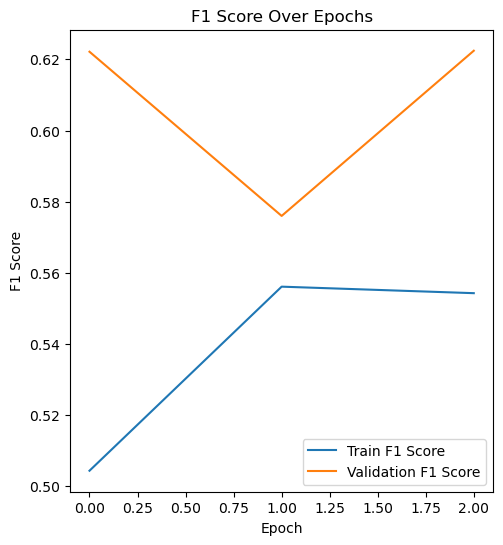

[I 2024-12-19 04:36:14,440] Trial 17 finished with value: 0.6224294900894165 and parameters: {'lstm_units': 126, 'dropout_rate': 0.2486470015997595, 'learning_rate': 0.006910429102042423, 'batch_size': 32}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - f1_score_metric: 0.3774 - loss: 1.5012f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - f1_score_metric: 0.3829 - loss: 1.4863 - val_f1_score_metric: 0.6570 - val_loss: 0.6206
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - f1_score_metric: 0.5057 - loss: 1.0437 - val_f1_score_metric: 0.6975 - val_loss: 0.5959
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - f1_score_metric: 0.5977 - loss: 0.9116 - val_f1_score_metric: 0.7039 - val_loss: 0.5774
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - f1_score_metric: 0.5800 - loss: 0.9071 - val_f1_score_metric: 0.7044 - val_loss: 0.5613
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - f1_score_metric: 0.5981 - loss: 0.8210 - val_f1_score_metric: 0.6903 - val_loss: 0.5482
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - f1_score_metric: 0.6

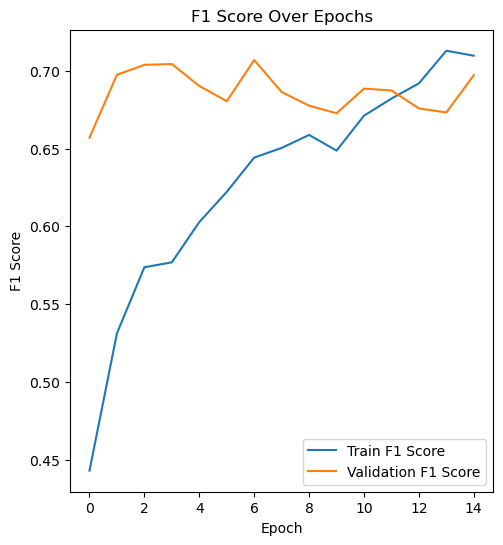

[I 2024-12-19 04:46:25,855] Trial 18 finished with value: 0.6971916556358337 and parameters: {'lstm_units': 94, 'dropout_rate': 0.27244144592242214, 'learning_rate': 0.00016669029188873144, 'batch_size': 128}. Best is trial 11 with value: 0.7025724053382874.


Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score_metric: 0.4418 - loss: 1.2486f1 Tensor("truediv_2:0", shape=(), dtype=float32)
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - f1_score_metric: 0.4446 - loss: 1.2418 - val_f1_score_metric: 0.6368 - val_loss: 0.5869
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - f1_score_metric: 0.6179 - loss: 0.8735 - val_f1_score_metric: 0.6402 - val_loss: 0.5375
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - f1_score_metric: 0.6088 - loss: 0.7970 - val_f1_score_metric: 0.6580 - val_loss: 0.5021
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - f1_score_metric: 0.6467 - loss: 0.7244 - val_f1_score_metric: 0.6440 - val_loss: 0.4652
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - f1_score_metric: 0.7040 - loss: 0.6496 - val_f1_score_metric: 0.6647 - val_loss: 0.4362
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - f1_score_metric: 0.6

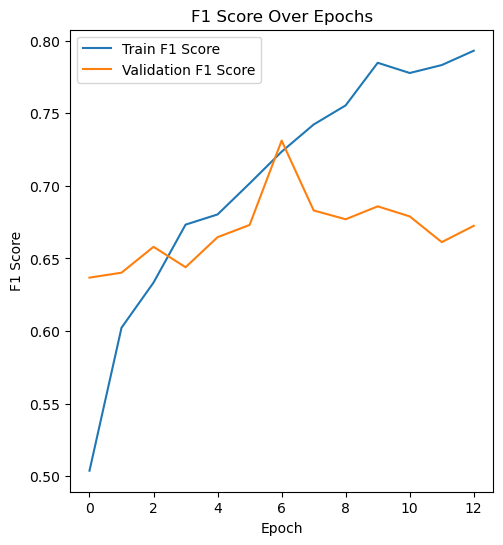

[I 2024-12-19 04:52:40,547] Trial 19 finished with value: 0.6725062131881714 and parameters: {'lstm_units': 62, 'dropout_rate': 0.2010299213971278, 'learning_rate': 0.0004678829643756747, 'batch_size': 64}. Best is trial 11 with value: 0.7025724053382874.


Best trial:
  Value (F1 score): 0.7025724053382874
  Params:
    lstm_units: 126
    dropout_rate: 0.20092677051689975
    learning_rate: 0.0005630074871552249
    batch_size: 128
Best hyperparameters: {'lstm_units': 126, 'dropout_rate': 0.20092677051689975, 'learning_rate': 0.0005630074871552249, 'batch_size': 128}
Epoch 1/15
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - f1_score_metric: 0.4671 - loss: 0.7152f1 Tensor("truediv_2:0", shape=(), dtype=float32)
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.4701 - loss: 0.7128 - val_f1_score_metric: 0.7368 - val_loss: 0.5447
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 55s 5s/step - f1_score_metric: 0.6102 - loss: 0.5234 - val_f1_score_metric: 0.6670 - val_loss: 0.5179
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step - f1_score_metric: 0.6548 - loss: 0.4394 - val_f1_score_metric: 0.6662 - val_loss: 0.4924
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━

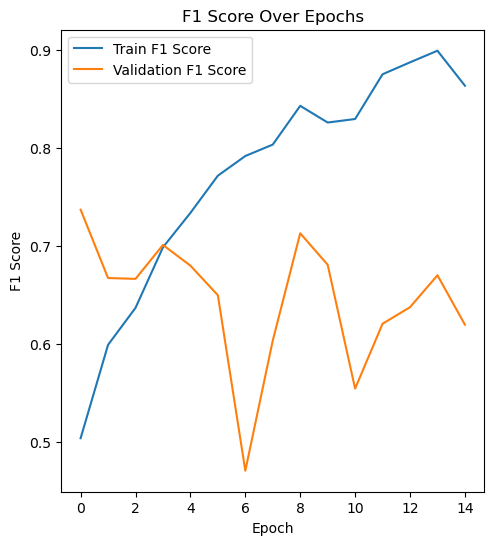

In [11]:
from optuna.samplers import TPESampler


input_shape = (x_train_np.shape[1], x_train_np.shape[2])  # (time_steps, features)
sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.

# Perform the hyperparameter optimization
study = optuna.create_study(direction='maximize', sampler=sampler)  # We want to maximize the F1 score
study.optimize(lambda trial: objective(trial, x_train_np, y_train_np, x_val_np, y_val_np, input_shape), n_trials=20)

# Print the best trial's hyperparameters and performance
print("Best trial:")
trial = study.best_trial
print(f"  Value (F1 score): {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Get the best hyperparameters
best_params = trial.params
print(f"Best hyperparameters: {best_params}")

# Train the model using the best hyperparameters
model = get_classification_model(input_shape, best_params['lstm_units'], best_params['dropout_rate'], best_params['learning_rate'])
history = model.fit(x_train_np, y_train_np, epochs=15, batch_size=best_params['batch_size'], validation_data=(x_val_np, y_val_np))

# Plot training and validation metrics
plot_metrics(history)

We then test the model on the best performing parameters we selected using optuna. We will also plot a confusion matrix that will be used for analysis of the results

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step
Test Loss: 0.36998897790908813
Test F1 Score: 0.5935283899307251
{'loss': 0.36998897790908813, 'f1_score': 0.5935283899307251}
Confusion matrix plot saved to plots_results/cm_BI_LSTM_F1FFT_tw022.png


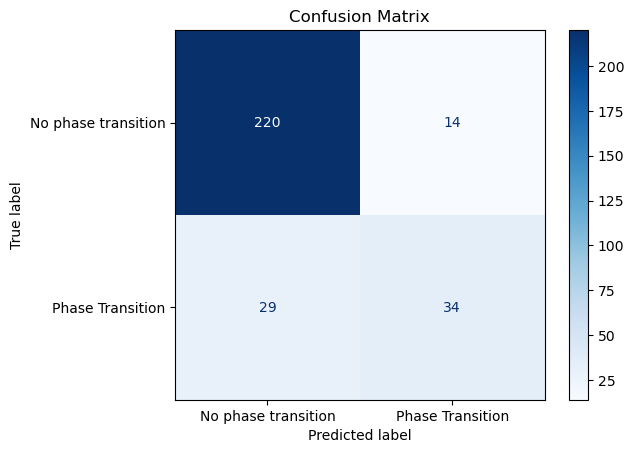

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model(model, x_test, y_test):
    """
    Evaluate the trained model on the test data and compute relevant metrics.

    Args:
        model (keras.Model): Trained Keras model.
        x_test (np.ndarray): Test features, shape=(N, time_steps, features).
        y_test (np.ndarray): True test labels, shape=(N,).

    Returns:
        dict: A dictionary containing the loss, accuracy, and F1 score.
    """
    # Evaluate the model on the test set
    loss, f1 = model.evaluate(x_test, y_test, verbose=0)

    print(f"Test Loss: {loss}")
    print(f"Test F1 Score: {f1}")

    # Return metrics in a dictionary
    return {"loss": loss, "f1_score": f1}

def plot_confusion_matrix(y_true, y_pred, class_names,save_path):
    """
    Plot and display a confusion matrix.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        class_names (list): List of class names.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    # Create the folder if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the plot
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Confusion matrix plot saved to {save_path}")
    plt.show()

#We follow the same procedure we used for train
# Convert test DataLoader to numpy arrays
x_test_np, y_test_np = data_loader_to_numpy(test_data_loader)
x_test_np = replace_nans_with_mean(x_test_np)

# Check for NaN or Inf values
if np.any(np.isnan(x_test_np)) or np.any(np.isinf(x_test_np)):
    print("NaN or Inf values found in x_test")

y_pred_np = model.predict(x_test_np)
y_pred_np = np.round(y_pred_np).flatten()  # Ensure predictions are binary

# Evaluate the model
test_results = test_model(model, x_test_np, y_test_np)

print(test_results)

# Plot the confusion matrix
class_names = ["No phase transition", "Phase Transition"]
plot_confusion_matrix(y_test_np, y_pred_np, class_names,"plots_results/cm_BI_LSTM_F1FFT_tw022.png")

